Imports

In [1]:
import copy
import torch
import numpy as np
import torch as pt
import torch.nn as nn
import torch.optim as optim
from sympy.codegen.ast import float64
from torch.nn import Sequential
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import scipy.io
from sympy import preview, shape
import datetime
import matplotlib.pyplot as plt
from sktime.libs.vmdpy import VMD

Global Variables

In [50]:
learning_rate = 0.0001
TRAINING_DEV = 'cuda'

subject_data = [r"Z:\projects\trial_classification\subj_009.mat"]

'''             r"Z:\projects\trial_classification\subj_009.mat",
                r"Z:\projects\trial_classification\subj_010.mat",
                r"Z:\projects\trial_classification\subj_011.mat",
                r"Z:\projects\trial_classification\subj_012.mat",
                r"Z:\projects\trial_classification\subj_013.mat",
                r"C:\\Users\imjus\Documents\SPANLab\Data\subj_014.mat"'''

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
C:\Users\imjus\AppData\Local\Temp\ipykernel_19288\3520205557.py:6: SyntaxWarning: invalid escape sequence '\p'
  '''             r"Z:\projects\trial_classification\subj_009.mat",


'             r"Z:\\projects\trial_classification\\subj_009.mat",\n                r"Z:\\projects\trial_classification\\subj_010.mat",\n                r"Z:\\projects\trial_classification\\subj_011.mat",\n                r"Z:\\projects\trial_classification\\subj_012.mat",\n                r"Z:\\projects\trial_classification\\subj_013.mat",\n                r"C:\\Users\\imjus\\Documents\\SPANLab\\Data\\subj_014.mat"'

In [3]:
class Test_Case:
    def __init__(self, trial_data, tone, voice_type):
        self.trial_data = trial_data
        self.tone = tone
        self.voice_type = voice_type

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float().to(TRAINING_DEV)  # Move x to CUDA
        self.y = torch.from_numpy(y).long().to(TRAINING_DEV)  # Move y to CUDA

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], (self.y[idx])

# Define the multi-class perceptron model
class MultiClassPerceptron(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassPerceptron, self).__init__()
        layer2 = input_size // 2
        layer3 = input_size // 4
        self.fc1 = nn.Linear(input_size, layer3)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(layer3, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        x = nn.Softmax(dim=1)(x)
        return x

Data Preprocessing

In [51]:
def load_data(file_path):
    data = scipy.io.loadmat(file_path)

    all_ffr = data['all_epochs']
    all_tone_clss = data['clss'].flatten()
    all_time = data['t'].flatten()

    return all_ffr, all_tone_clss, all_time

# 0 - 3 are T1 - T4
def map_tone(tone_value):
    if tone_value in [1, 5, 9, 13]:
        return 0
    elif tone_value in [2, 6, 10, 14]:
        return 1
    elif tone_value in [3, 7, 11, 15]:
        return 2
    elif tone_value in [4, 8, 12, 16]:
        return 3
    else: print("\n\n\n******* ERROR IN DATA *******\n\n\n")

def subaverage_data(all_ffr, all_tone_clss, all_time, sub_average_size):
    print("Sub_average_size:", sub_average_size)
    partially_organized_ffr_data = np.empty((all_tone_clss.size, all_time.size))
    for i in range(all_tone_clss.size):
        partially_organized_ffr_data[i,:] = all_ffr[:,i]

    # Slices array where time is less than 20ms, leaving only data between 20ms and 350ms
    index1 = 0;  # 20ms index
    for i in range(all_time.size):
        if(all_time[i] < 20): continue
        elif(index1 == 0): index1 = i
        elif(all_time[i] > 300):
            partially_organized_ffr_data = partially_organized_ffr_data[:, index1:i]
            break

    '''This section creates the subaverage array and computes the subaverages based on our predefined
        subaverage number'''
    clss = 1
    temp_trials = class_data = [[] for _ in range(16)]
    temp_clss = [[] for _ in range(16)]
    prev = 0
    for i in range(partially_organized_ffr_data.shape[0]):
        if all_tone_clss[i] != clss:
            temp_trials[clss - 1] = partially_organized_ffr_data[prev:i]
            temp_clss[clss - 1] = all_tone_clss[prev:i]
            prev = i
            clss += 1
    # Handles the final case
    temp_trials[clss - 1] = partially_organized_ffr_data[prev:]
    temp_clss[clss - 1] = all_tone_clss[prev:]

    sub_averaged_trials_temp = [[] for _ in range(16)]
    sub_averaged_trial_clss_temp = [[] for _ in range(16)]
    test_trials_temp = [[] for _ in range(16)]
    test_trial_clss_temp = [[] for _ in range(16)]
    for i in range(16):
        # Randomly shuffle the trials for class i
        ''' TODO LOOK AT THIS '''
        perm = np.random.permutation(len(temp_trials[i]))
        shuffled_trials = np.array(temp_trials[i])[perm]

        temp_element = np.zeros(partially_organized_ffr_data.shape[1])  # Initialize as NumPy array

        for j, element in enumerate(shuffled_trials):
            temp_element += element  # Accumulate trial values

            # When sub_average_size trials are accumulated, compute the mean
            if (j+1) % sub_average_size == 0:
                temp_element = temp_element / sub_average_size  # Compute mean
                sub_averaged_trials_temp[i].append(temp_element)  # Store the averaged trial
                sub_averaged_trial_clss_temp[i].append(i + 1)  # Store the class label

                # Reset temp_element and count for the next group
                temp_element = np.zeros(partially_organized_ffr_data.shape[1])

        num_trials = len(sub_averaged_trials_temp[i])
        test_split_index = num_trials - (num_trials // 5)  # 20% goes to testing

        # Splits test data
        test_trials_temp[i] = sub_averaged_trials_temp[i][test_split_index:]
        test_trial_clss_temp[i] = sub_averaged_trial_clss_temp[i][test_split_index:]
        sub_averaged_trials_temp[i] = sub_averaged_trials_temp[i][:test_split_index]
        sub_averaged_trial_clss_temp[i] = sub_averaged_trial_clss_temp[i][:test_split_index]

    # This part of the code combines the lists into 2D arrays instead of 3D ones
    sub_averaged_trials = [element for sublist1 in sub_averaged_trials_temp for element in sublist1]
    sub_averaged_trial_clss = [element for sublist1 in sub_averaged_trial_clss_temp for element in sublist1]
    test_trials = [element for sublist1 in test_trials_temp for element in sublist1]
    test_trial_clss = [element for sublist1 in test_trial_clss_temp for element in sublist1]

    return sub_averaged_trials, sub_averaged_trial_clss, test_trials, test_trial_clss

def get_data(sub_average_size):
    sub_averaged_trials = []
    sub_averaged_trial_clss = []
    test_trials = []
    test_trial_clss = []

    for file_path in subject_data:
        # Load the data from the file
        all_ffr, all_tone_clss, all_time = load_data(file_path)

        # Subaverage the data
        sub_averaged_trials_temp, sub_averaged_trial_clss_temp, test_trials_temp, test_trial_clss_temp = subaverage_data(all_ffr, all_tone_clss, all_time, sub_average_size)

        # Append the results to the global lists
        sub_averaged_trials.append(sub_averaged_trials_temp)
        sub_averaged_trial_clss.append(sub_averaged_trial_clss_temp)
        test_trials.append(test_trials_temp)
        test_trial_clss.append(test_trial_clss_temp)

    sub_averaged_trials = np.concatenate(sub_averaged_trials, axis=0)
    sub_averaged_trial_clss = np.concatenate(sub_averaged_trial_clss, axis=0)
    test_trials = np.concatenate(test_trials, axis=0)
    test_trial_clss = np.concatenate(test_trial_clss, axis=0)

    if len(test_trials) == 0: raise ValueError("Subaverage Too Large !!!")

    return sub_averaged_trials, sub_averaged_trial_clss, test_trials, test_trial_clss


In [5]:
def training_inst(training_dataset, perceptron, optimizer, criterion, num_epochs, epoch_incr, testing_dataset):
    data_loader = DataLoader(training_dataset, batch_size=512, shuffle=True)
    perceptron.to(TRAINING_DEV)

    accuracy_matrices = np.empty((0, 4, 4))

    # Train the model
    for epoch in range(num_epochs):
        perceptron.train()
        correct = 0
        total = 0
        for i, (data, target) in enumerate(data_loader):
            data = data.to(TRAINING_DEV)
            target = target.to(TRAINING_DEV)

            output = perceptron(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            correct += torch.sum(torch.eq(torch.argmax(output, dim=1), target)).item()
            total += target.size(0)

        if(epoch % epoch_incr == 0):
            accuracy_matrices = np.concatenate(
                (accuracy_matrices, testing_inst(testing_dataset, perceptron)[np.newaxis, :, :]), axis=0)
            print(accuracy_matrices.shape)
        print(correct / total)
    print(accuracy_matrices.shape)

    accuracy_matrices = np.concatenate((accuracy_matrices, testing_inst(testing_dataset, perceptron)[np.newaxis, :, :]),
                                       axis=0)
    print()

    return accuracy_matrices

def testing_inst(dataset, perceptron):
    accuracy_matrix = np.zeros((4, 4))

    accuracy = 0
    total = 0

    # Test the accuracy of Male Model
    data_loader = DataLoader(dataset)
    for i, (data, target) in enumerate(data_loader):
        perceptron.eval()
        data = data.to(TRAINING_DEV)
        target = target.to(TRAINING_DEV)

        output = perceptron(data)

        accuracy += torch.sum(torch.eq(torch.argmax(output, dim=1), target)).item()
        total += target.size(0)
        predictions = torch.argmax(output, axis=1).to('cpu')
        for pred, true in zip(predictions, target.to('cpu')):
            accuracy_matrix[pred.item()][true.item()] += 1

    print(accuracy / total)
    print(accuracy_matrix)

    return accuracy_matrix

def instance_of_model(sub_averaged_trials, sub_averaged_trial_clss, test_data, test_data_clss, num_epochs, epoch_incr):
    print("Num Epochs:", num_epochs)
    # Radomizes the order of trials for training
    temp = np.random.permutation(sub_averaged_trials.shape[0])

    # Removes Test Data from training data
    training_data = sub_averaged_trials[temp]
    training_data_clss = sub_averaged_trial_clss[temp]

    # Split test and training data into male and female classes
    training_data_male = np.empty((0, training_data.shape[1]))
    training_data_male_clss = np.empty(0)
    training_data_female = np.empty((0, training_data.shape[1]))
    training_data_female_clss = np.empty(0)

    test_cases_male = np.empty((0, training_data.shape[1]))
    test_cases_male_clss = np.empty(0)
    test_cases_female = np.empty((0, training_data.shape[1]))
    test_cases_female_clss = np.empty(0)


    for i, data in enumerate(training_data_clss):
        if(data in [1, 2, 3, 4, 5, 6, 7, 8]):
            training_data_male = np.vstack((training_data_male, training_data[i]))
            training_data_male_clss = np.append(training_data_male_clss, map_tone(data))
        elif(data in [9, 10, 11, 12, 13, 14, 15, 16]):
            training_data_female = np.vstack((training_data_female, training_data[i]))
            training_data_female_clss = np.append(training_data_female_clss, map_tone(data))

    for i, data in enumerate(test_data_clss):
        if(data in [1, 2, 3, 4, 5, 6, 7, 8]):
            test_cases_male = np.vstack((test_cases_male, test_data[i]))
            test_cases_male_clss = np.append(test_cases_male_clss, map_tone(data))
        elif(data in [9, 10, 11, 12, 13, 14, 15, 16]):
            test_cases_female = np.vstack((test_cases_female, test_data[i]))
            test_cases_female_clss = np.append(test_cases_female_clss, map_tone(data))


    print("Male:", test_cases_male.shape, test_cases_male_clss.size)
    print("Female:", test_cases_female.shape, test_cases_female_clss.size)

    """MULTI CLASS PERCEPTION"""

    # Create dataset and data loader
    training_dataset_male = CustomDataset(training_data_male, training_data_male_clss)
    testing_dataset_male = CustomDataset(test_cases_male, test_cases_male_clss)

    training_dataset_female = CustomDataset(training_data_female, training_data_female_clss)
    testing_dataset_female = CustomDataset(test_cases_female, test_cases_female_clss)

    for i, data in enumerate(test_data_clss):
        test_data_clss[i] = map_tone(data)
    for i, data in enumerate(training_data_clss):
        training_data_clss[i] = map_tone(data)

    training_dataset_general = CustomDataset(training_data, training_data_clss)
    testing_dataset_general = CustomDataset(test_data, test_data_clss)

    # Initialize the model
    input_size = sub_averaged_trials.shape[1]  # Number of features in the input
    num_classes = 4  # T1 - T4

    female_perceptron = MultiClassPerceptron(input_size, num_classes)
    male_perceptron = MultiClassPerceptron(input_size, num_classes)
    general_perceptron = MultiClassPerceptron(input_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    male_optimizer = optim.Adam(male_perceptron.parameters(), lr=learning_rate)
    female_optimizer = optim.Adam(female_perceptron.parameters(), lr=learning_rate)
    general_optimizer = optim.Adam(general_perceptron.parameters(), lr=learning_rate)

    male_matrices = training_inst(training_dataset_male, male_perceptron, male_optimizer, criterion, num_epochs, epoch_incr, testing_dataset_male)
    female_matrices = training_inst(training_dataset_female, female_perceptron, female_optimizer, criterion, num_epochs, epoch_incr, testing_dataset_female)
    general_matrices = training_inst(training_dataset_general, general_perceptron, general_optimizer, criterion, num_epochs, epoch_incr, testing_dataset_general)

    # Test the accuracy of Male, Female, and General Models
    '''
    male_voice_accuracy_matrix = testing_inst(testing_dataset_male, male_perceptron)
    female_voice_accuracy_matrix = testing_inst(testing_dataset_female, female_perceptron)
    general_voice_accuracy_matrix = testing_inst(testing_dataset_general, general_perceptron)
    '''

    return general_matrices, male_matrices, female_matrices


''' Input should be a 4x4 integer matrix.
    Returns a string representation of averages. '''
def get_accuracy(matrix):
    correct = 0;
    total = 0;

    partial_output = ""

    # Correct Label
    for i in range(4):
        t_corr = 0
        t_total = 0
        # Model prediction
        for j in range(4):
            if i == j:
                correct += matrix[j][i]
                t_corr += matrix[j][i]
            total += matrix[j][i]
            t_total += matrix[j][i]

        partial_output = partial_output + "T" + (i + 1).__str__() + ": " + (int(t_corr)).__str__() + "/" + (int(t_total)).__str__() + " "

    output = "Accuracy: " + (correct/total).__str__() + "\n" + partial_output + "\n"
    return output, (correct/total)


In [8]:
""" EPOCH AND SUBAVERAGE OPTIMIZATION DATA """
now = datetime.datetime.now()

# THESE ARE MEANT TO BE EDITED DEPENDING ON WHO IS RUNNING THE DATA
max_epochs = 300
epoch_incr = 25
max_sub_average = 1
starting_sub_average = 1
sub_average_incr = 5
num_iterations_per_average = 25

file1 = open("Human_Readable_Data.txt", "w")
file2 = open("Averages_Data.txt", "w")

epoch_range = "Epoch Range: 0 - " + max_epochs.__str__() + "\n"
sub_average_range = "Sub Average Range: " + starting_sub_average.__str__() + " - " + max_sub_average.__str__() + "\n"
num_iter_str = "Iterations Per Matrix (number of models trained per epoch-sub_average instance): " + num_iterations_per_average.__str__() + "\n\n"
date = "Date: " + now.__str__() + "\n"

file1.write("***** CODE WRITTEN BY SAM KRAJEWSKI *****\n\n")

file1.write(date)
file1.write(epoch_range)
file1.write(sub_average_range)
file1.write(num_iter_str)

file2.write("sub_average_size,num_epochs,general_accuracy,male_accuracy,female_accuracy\n")

for sub_average_size in range(starting_sub_average, max_sub_average + 1, sub_average_incr):
    num_tests = (max_epochs // epoch_incr) + 1

    male_epoch_accuracy_matrices = np.zeros((num_tests, 4, 4))
    female_epoch_accuracy_matrices = np.zeros((num_tests, 4, 4))
    general_epoch_accuracy_matrices = np.zeros((num_tests, 4, 4))

    for i in range(num_iterations_per_average):
        sub_averaged_trials, sub_averaged_trial_clss, test_data, test_data_clss = get_data(sub_average_size)
        general, male, female = instance_of_model(sub_averaged_trials, sub_averaged_trial_clss, test_data, test_data_clss, max_epochs, epoch_incr)

        general_epoch_accuracy_matrices += general
        male_epoch_accuracy_matrices += male
        female_epoch_accuracy_matrices += female

    for i, element in enumerate(general_epoch_accuracy_matrices):
        string = "Sub-Average Size: " + sub_average_size.__str__() + "    Num Epochs: " + (i * epoch_incr).__str__() + "\n"
        file1.write(string)
        file1.write("General ")
        file1.write(get_accuracy(element)[0])
        file1.write(element.__str__())
        file1.write("\n")
        file1.write("Male ")
        file1.write(get_accuracy(male_epoch_accuracy_matrices[i])[0])
        file1.write(male_epoch_accuracy_matrices[i].__str__())
        file1.write("\n")
        file1.write("Female ")
        file1.write(get_accuracy(female_epoch_accuracy_matrices[i])[0])
        file1.write(female_epoch_accuracy_matrices[i].__str__())
        file1.write("\n")

        string = sub_average_size.__str__() + "," + (i * epoch_incr).__str__() + "," + get_accuracy(element)[1].__str__() + "," + get_accuracy(male_epoch_accuracy_matrices[i])[1].__str__() + "," + get_accuracy(female_epoch_accuracy_matrices[i])[1].__str__() + "\n"
        file2.write(string)

file1.close
file2.close


Sub_average_size: 1
Num Epochs: 300
Male: (550, 1400) 550
Female: (547, 1400) 547
0.27636363636363637
[[41. 40. 37. 27.]
 [53. 61. 66. 65.]
 [18. 13. 16. 11.]
 [26. 22. 20. 34.]]
(1, 4, 4)
0.2444745151105097
0.2796571944068561
0.3261163734776725
0.36851601262967976
0.4140730717185386
0.4497068110058638
0.4889490302210194
0.4952638700947226
0.5399188092016238
0.5498421290031574
0.5611186287776274
0.6111862877762743
0.6197564276048715
0.6269733874605322
0.6337392873252142
0.6671177266576455
0.6792963464140731
0.6792963464140731
0.7041046459179071
0.7068110058637799
0.7140279657194407
0.7383852052322959
0.7419936851601263
0.7541723049165538
0.7690572846188543
0.39636363636363636
[[60. 37. 25. 23.]
 [28. 45. 28. 37.]
 [25. 24. 59. 23.]
 [25. 30. 27. 54.]]
(2, 4, 4)
0.7658998646820027
0.7866486242670275
0.7961208840775823
0.8010825439783491
0.8042399639152007
0.8119079837618404
0.815065403698692
0.8258908434821831
0.8231844835363104
0.8308525033829499
0.8389715832205683
0.8439332431213351
0

KeyboardInterrupt: 

Sub_average_size: 1


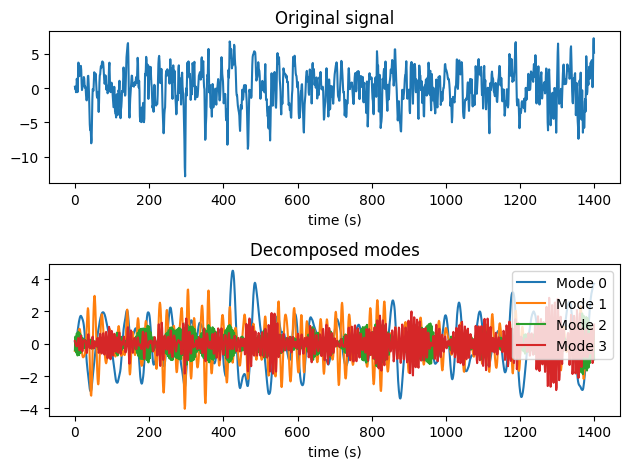

16
i: 0; Num Trials Being Avg'd: 272
i: 1; Num Trials Being Avg'd: 283
i: 2; Num Trials Being Avg'd: 300
i: 3; Num Trials Being Avg'd: 310
i: 4; Num Trials Being Avg'd: 286
i: 5; Num Trials Being Avg'd: 298
i: 6; Num Trials Being Avg'd: 300
i: 7; Num Trials Being Avg'd: 292
i: 8; Num Trials Being Avg'd: 293
i: 9; Num Trials Being Avg'd: 276
i: 10; Num Trials Being Avg'd: 321
i: 11; Num Trials Being Avg'd: 322
i: 12; Num Trials Being Avg'd: 293
i: 13; Num Trials Being Avg'd: 283
i: 14; Num Trials Being Avg'd: 330
i: 15; Num Trials Being Avg'd: 312


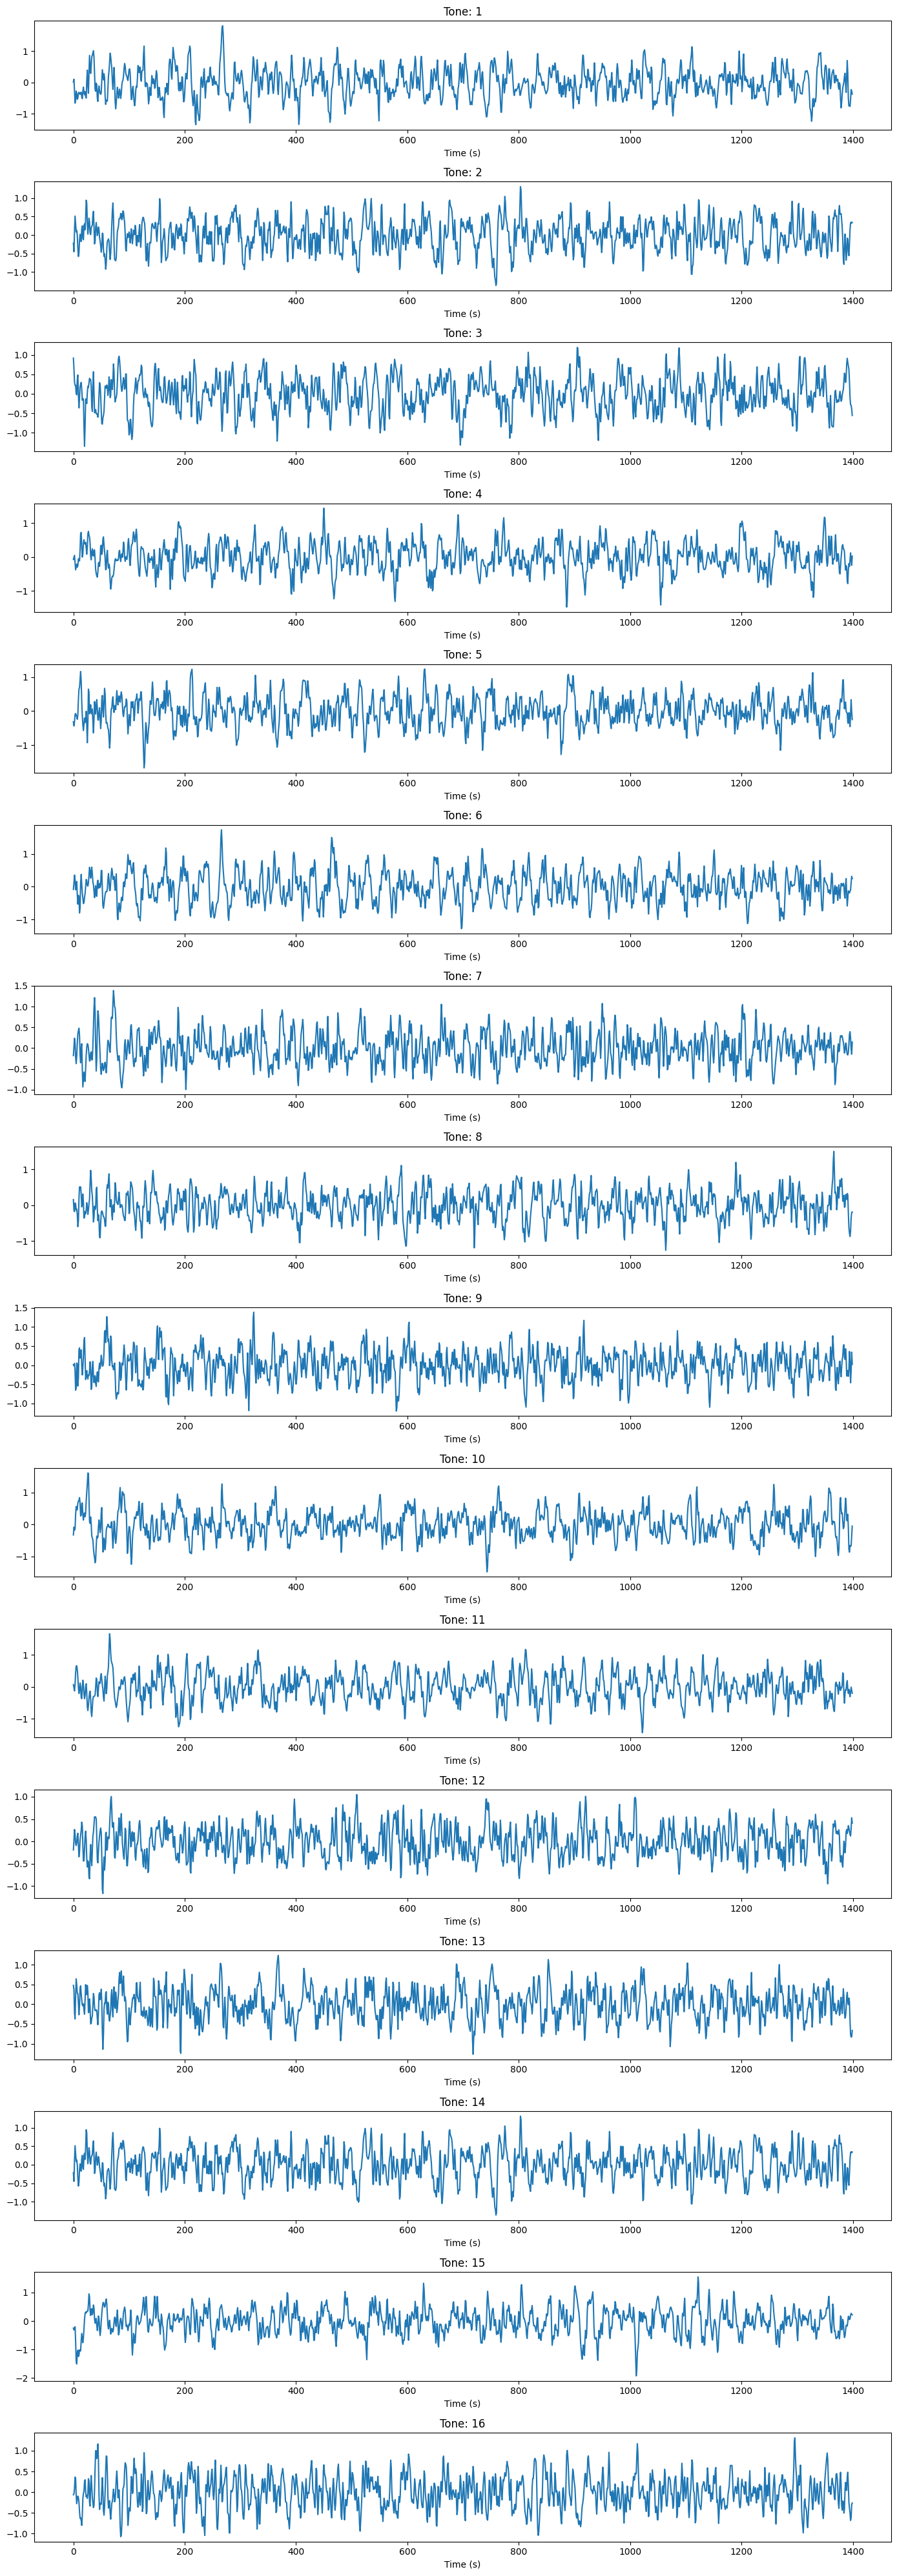

In [52]:
''' This method should only be used with data from a single subject'''
def get_ground_truth_and_single_trials(all_ffr, all_tone_clss, all_time):
    # Flips array to get trial * time.
    partially_organized_ffr_data = np.empty((all_tone_clss.size, all_time.size))
    for i in range(all_tone_clss.size):
        partially_organized_ffr_data[i,:] = all_ffr[:,i]

    # Slices array where time is less than 20ms, leaving only data between 20ms and 350ms
    index1 = 0;  # 20ms index
    for i in range(all_time.size):
        if(all_time[i] < 20): continue
        elif(index1 == 0): index1 = i
        elif(all_time[i] > 300):
            partially_organized_ffr_data = partially_organized_ffr_data[:, index1:i]
            break

    ''' This section gets the ground truth for each tone (1-16)'''
    clss = 1
    single_trials = class_data = [[] for _ in range(16)]
    temp_clss = [[] for _ in range(16)]
    prev = 0
    for i in range(partially_organized_ffr_data.shape[0]):
        if all_tone_clss[i] != clss:
            single_trials[clss - 1] = partially_organized_ffr_data[prev:i]
            temp_clss[clss - 1] = all_tone_clss[prev:i]
            prev = i
            clss += 1
    # Handles the final case
    single_trials[clss - 1] = partially_organized_ffr_data[prev:]
    temp_clss[clss - 1] = all_tone_clss[prev:]

    ground_truth = [[] for _ in range(16)]

    print(len(single_trials))

    for k, arr in enumerate(single_trials):
        print("i: " + k.__str__() + "; Num Trials Being Avg'd: " +  len(arr).__str__())
        num_cols = len(arr[0])
        averages = []

        for j in range(num_cols):
            column_sum = 0
            for i in range(len(arr)):
                column_sum += arr[i][j]
            averages.append(column_sum / len(arr))

        ground_truth[k] = averages

    return ground_truth, single_trials


''' This calls our function '''
all_ffr, all_tone_clss, all_time = load_data(subject_data[0])
ground_truth, single_trials = get_ground_truth_and_single_trials(all_ffr, all_tone_clss, all_time)

''' Plots the ground truths '''
plt.figure(figsize=(14, 40))

for i, arr in enumerate(ground_truth):
    plt.subplot(16, 1, i + 1)
    plt.plot(arr)
    plt.title(f"Tone: {i + 1}")
    plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()


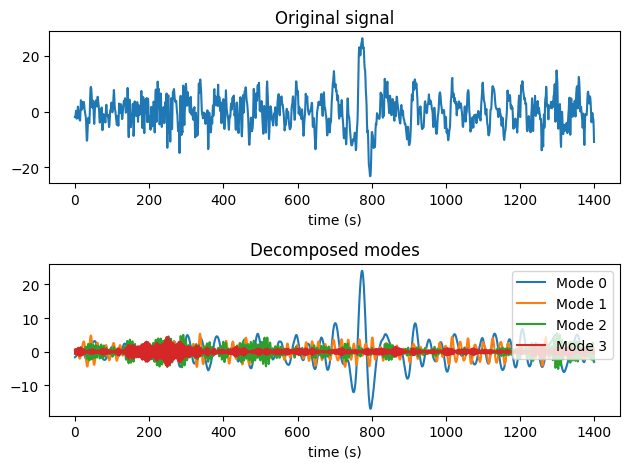

In [35]:
# some sample parameters for VMD
alpha = 2000  # moderate bandwidth constraint
tau = 0.0  # noise-tolerance (no strict fidelity enforcement)
K = 4  # 3 modes
DC = 0  # no DC part imposed
init = 1  # initialize omegas uniformly
tol = 1e-7

f = single_trials[0][0]

# Run VMD
u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)

# Visualize decomposed modes

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(f)
plt.title("Original signal")
plt.xlabel("time (s)")
plt.subplot(2, 1, 2)
plt.plot(u.T)
plt.title("Decomposed modes")
plt.xlabel("time (s)")
plt.legend(["Mode %d" % m_i for m_i in range(u.shape[0])])
plt.tight_layout()

In [37]:
ground = ground_truth[0]

VMDcorrelation = np.corrcoef(ground, u[0])
correlation = np.corrcoef(ground, f)

print("VMD Correlation:")
print(VMDcorrelation)
print("Single Trial Correlation:")
print(correlation)

VMD Correlation:
[[1.         0.06267097]
 [0.06267097 1.        ]]
Single Trial Correlation:
[[1.         0.08923034]
 [0.08923034 1.        ]]


VMD MODELS

In [17]:
""" EPOCH AND SUBAVERAGE OPTIMIZATION DATA """
now = datetime.datetime.now()

alpha = 2000  # moderate bandwidth constraint
tau = 0.0  # noise-tolerance (no strict fidelity enforcement)
K = 4  # 3 modes
DC = 0  # no DC part imp
init = 1  # initialize omegas uniformly
tol = 1e-7

# THESE ARE MEANT TO BE EDITED DEPENDING ON WHO IS RUNNING THE DATA
max_epochs = 300
epoch_incr = 25
max_sub_average = 5
starting_sub_average = 5
sub_average_incr = 1
num_iterations_per_average = 2

file1 = open("Human_Readable_Data.txt", "w")
file2 = open("Averages_Data.txt", "w")

epoch_range = "Epoch Range: 0 - " + max_epochs.__str__() + "\n"
sub_average_range = "Sub Average Range: " + starting_sub_average.__str__() + " - " + max_sub_average.__str__() + "\n"
num_iter_str = "Iterations Per Matrix (number of models trained per epoch-sub_average instance): " + num_iterations_per_average.__str__() + "\n\n"
date = "Date: " + now.__str__() + "\n"

file1.write("***** CODE WRITTEN BY SAM KRAJEWSKI *****\n\n")

file1.write(date)
file1.write(epoch_range)
file1.write(sub_average_range)
file1.write(num_iter_str)

file2.write("sub_average_size,num_epochs,general_accuracy,male_accuracy,female_accuracy\n")

for sub_average_size in range(starting_sub_average, max_sub_average + 1, sub_average_incr):
    num_tests = (max_epochs // epoch_incr) + 1

    male_epoch_accuracy_matrices = np.zeros((num_tests, 4, 4))
    female_epoch_accuracy_matrices = np.zeros((num_tests, 4, 4))
    general_epoch_accuracy_matrices = np.zeros((num_tests, 4, 4))

    for i in range(num_iterations_per_average):
        sub_averaged_trials, sub_averaged_trial_clss, test_data, test_data_clss = get_data(sub_average_size)

        # Define new shapes
        new_shape = (sub_averaged_trials.shape[0], sub_averaged_trials.shape[1] * 2)
        new_test_shape = (test_data.shape[0], test_data.shape[1] * 2)

        # Initialize arrays with the new shape
        vmd_trials = np.empty(new_shape)
        vmd_test_trials = np.empty(new_test_shape)

        for i, trial in enumerate(sub_averaged_trials):
            u, u_hat, omega = VMD(trial, alpha, tau, K, DC, init, tol)
            # Concatenate u[0] and u[1]
            combined = np.concatenate((u[0], u[1]), axis=0)
            # Store in vmd_trials
            vmd_trials[i] = combined

        for i, trial in enumerate(test_data):
            u, u_hat, omega = VMD(trial, alpha, tau, K, DC, init, tol)
            # Concatenate u[0] and u[1]
            combined = np.concatenate((u[0], u[1]), axis=0)
            # Store in vmd_test_trials
            vmd_test_trials[i] = combined

        general, male, female = instance_of_model(vmd_trials, sub_averaged_trial_clss, vmd_test_trials, test_data_clss, max_epochs, epoch_incr)

        general_epoch_accuracy_matrices += general
        male_epoch_accuracy_matrices += male
        female_epoch_accuracy_matrices += female

    for i, element in enumerate(general_epoch_accuracy_matrices):
        string = "Sub-Average Size: " + sub_average_size.__str__() + "    Num Epochs: " + (i * epoch_incr).__str__() + "\n"
        file1.write(string)
        file1.write("General ")
        file1.write(get_accuracy(element)[0])
        file1.write(element.__str__())
        file1.write("\n")
        file1.write("Male ")
        file1.write(get_accuracy(male_epoch_accuracy_matrices[i])[0])
        file1.write(male_epoch_accuracy_matrices[i].__str__())
        file1.write("\n")
        file1.write("Female ")
        file1.write(get_accuracy(female_epoch_accuracy_matrices[i])[0])
        file1.write(female_epoch_accuracy_matrices[i].__str__())
        file1.write("\n")

        string = sub_average_size.__str__() + "," + (i * epoch_incr).__str__() + "," + get_accuracy(element)[1].__str__() + "," + get_accuracy(male_epoch_accuracy_matrices[i])[1].__str__() + "," + get_accuracy(female_epoch_accuracy_matrices[i])[1].__str__() + "\n"
        file2.write(string)

file1.close()
file2.close()

Sub_average_size: 5
Num Epochs: 300
Male: (105, 2800) 105
Female: (105, 2800) 105
0.38095238095238093
[[20. 18. 15. 19.]
 [ 1.  6.  2.  0.]
 [ 2.  1.  8.  1.]
 [ 3.  1.  2.  6.]]
(1, 4, 4)
0.22696629213483147
0.3842696629213483
0.4449438202247191
0.5685393258426966
0.5932584269662922
0.6629213483146067
0.698876404494382
0.7213483146067415
0.7595505617977528
0.7640449438202247
0.8067415730337079
0.8179775280898877
0.8202247191011236
0.8449438202247191
0.8539325842696629
0.851685393258427
0.8719101123595505
0.8606741573033708
0.8786516853932584
0.8808988764044944
0.8966292134831461
0.903370786516854
0.9101123595505618
0.9168539325842696
0.9123595505617977
0.4857142857142857
[[15.  8.  2.  8.]
 [ 4.  8.  1.  5.]
 [ 5.  2. 18.  3.]
 [ 2.  8.  6. 10.]]
(2, 4, 4)
0.9280898876404494
0.9191011235955057
0.9123595505617977
0.9303370786516854
0.9303370786516854
0.9393258426966292
0.9370786516853933
0.9393258426966292
0.9325842696629213
0.946067415730337
0.9483146067415731
0.9550561797752809
0.955